<a href="https://colab.research.google.com/github/zeyadmageid/GAN_fashion_project/blob/main/GAN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Stuff

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
ds = tfds.load('fashion_mnist',split = 'train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1AKT1Q/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1AKT1Q/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# Visualize data and build data set

In [ ]:
import numpy as np
dataiterator = ds.as_numpy_iterator()

In [ ]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

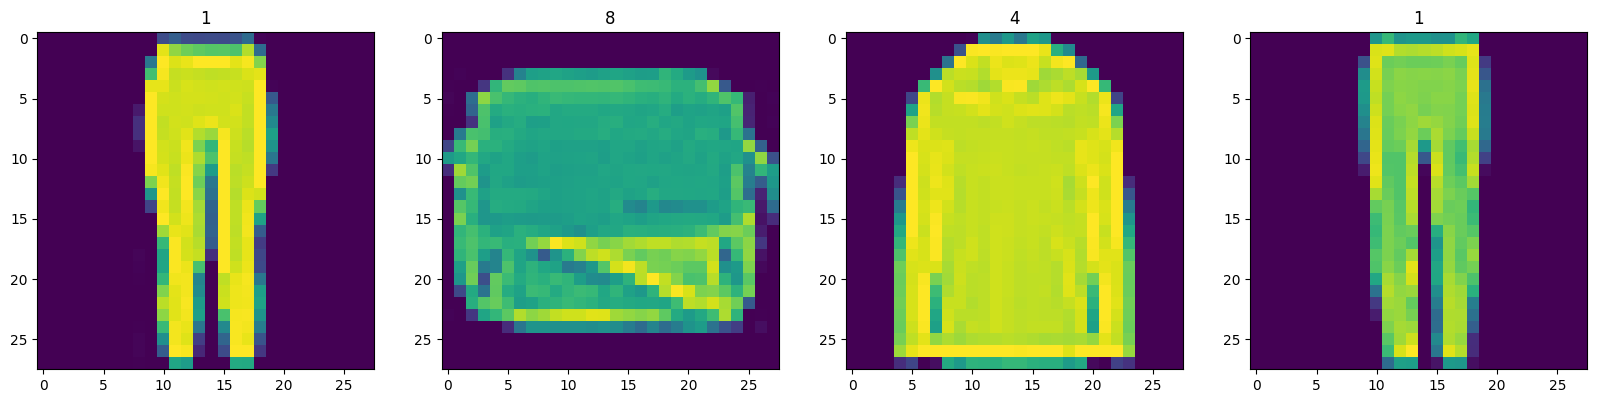

In [ ]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

In [ ]:
def scale_images(data):
  image = data['image']
  return image/255

In [ ]:
# reload dataset
ds = tfds.load('fashion_mnist',split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128) #128 images per sample
ds = ds.prefetch(64)

# Build NNs

## Import Modelling Components

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## Build Generator

In [ ]:
def build_generator():
  model = Sequential()

  #takes in random values and reshapes it to 7 by 7 by 128
  #beginning of generated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #upscaling block 1
  model.add(UpSampling2D()) # 14 x 14 x 128
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #upscaling block 2
  model.add(UpSampling2D()) # 14 x 14 x 128
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #convolutional block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #convolutional block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #final layer for one channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid')) #sigmoid because we want between zero and one


  return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 7s 7s/step


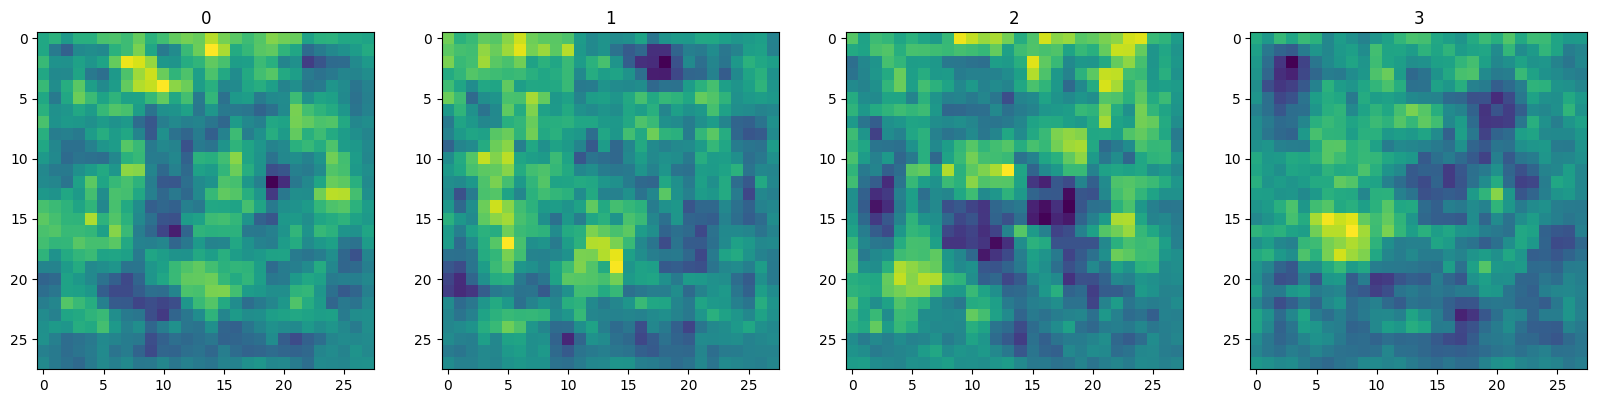

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Grab an image and label
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

## Build Discriminator

In [ ]:
def build_discriminator():
  model = Sequential()

  #first convo block
  model.add(Conv2D(32, 5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #second convo block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))


  #third convo block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #fourth convo block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 163ms/step


array([[0.49294066]], dtype=float32)

# Construct Training Loop

## Setup Losses and Optimizers

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy #loss function for both

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001) #must be slower so that generator has time to learn
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## Build Subclassed Model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args,**kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss , *args, **kwargs):
    #compile with base class
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    pass
  def train_step(self, batch):
    #get data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training = False)

    #Train the discriminator
    with tf.GradientTape() as d_tape:

      # pass the real and fake images through disc. model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake], axis = 0) # PREDICTIONS of the discriminator

      # create labels for real and fake images (actual values)
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0) #zero for real and one for fake

      # add some noise to outputs for disc. to not learn too fast

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real,noise_fake],axis=0)

      # calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)


    # apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training = True)

      # Create predicted labels
      predicted_labels = self.discriminator(gen_images, training= False)

      # Calc. loss - Trick to training to fake out the discriminator - Zero is label of real images
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)


    # Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return{"d_loss": total_d_loss, "g_loss": total_g_loss}

In [ ]:
fashgan = FashionGAN(generator,discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## Train

In [ ]:
hist = fashgan.fit(ds,epochs = 2000, callbacks=[ModelMonitor()])

Epoch 1/2000
469/469 [==============================] - 26s 28ms/step - d_loss: 0.4634 - g_loss: 1.0462
Epoch 2/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.5696 - g_loss: 2.3070
Epoch 3/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.6646 - g_loss: 0.7115
Epoch 4/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.6699 - g_loss: 0.4710
Epoch 5/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.6966 - g_loss: 0.5666
Epoch 6/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.6765 - g_loss: 0.5317
Epoch 7/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.6936 - g_loss: 0.5834
Epoch 8/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.6892 - g_loss: 0.6105
Epoch 9/2000
469/469 [==============================] - 12s 26ms/step - d_loss: 0.6849 - g_loss: 0.6317
Epoch 10/2000
469/469 [==============================] - 12s 26m

## Review Performance

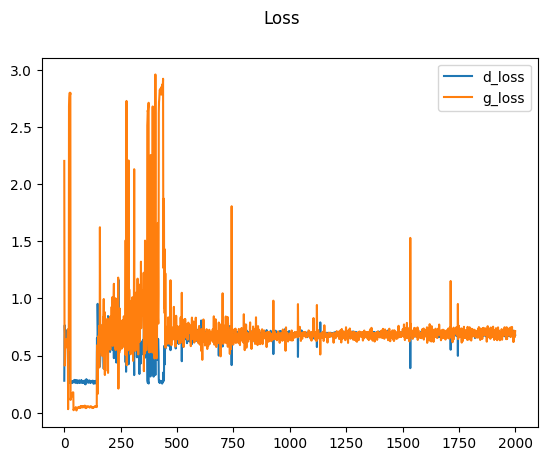

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Generate new fashion!

1/1 [==============================] - 0s 154ms/step


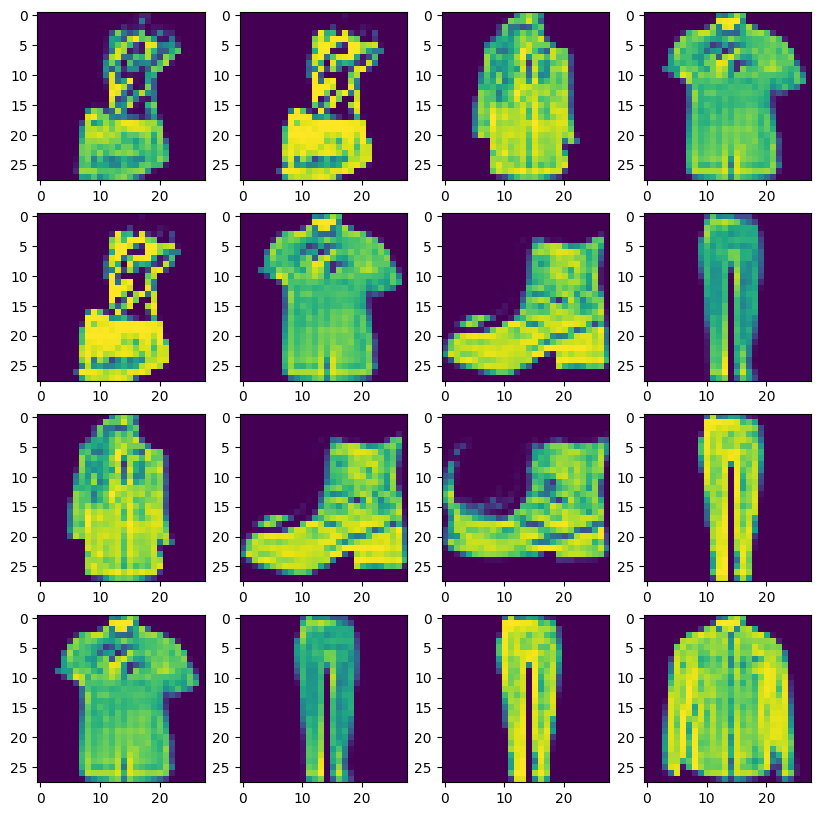

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])